In [2]:
# load some standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math #math fun
import matplotlib.pyplot as plt #plotting
from mpl_toolkits.mplot3d import Axes3D #3d plots
from sklearn.neighbors import NearestNeighbors 

In [3]:
import zipfile
z = zipfile.ZipFile(r"..\Data\historical-hourly-weather-data.zip")

In [4]:
cityTable = pd.read_csv(z.open("city_attributes.csv"))
temperatureDF = pd.read_csv(z.open("temperature.csv"), index_col=0)
temperatureDF.index = pd.to_datetime(temperatureDF.index)

In [5]:
def takensEmbedding (data,delay,dimension):
    if delay*dimension > len(data):
          raise NameError('Delay times dimension exceed length of data!')    
    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    
    return embeddedData;
        

In [6]:
t = pd.date_range(pd.to_datetime('22/6/2015', dayfirst=True), pd.to_datetime('31/8/2015', dayfirst=True), freq='H')

In [7]:
len(temperatureDF),len(t),min(t),max(t)

(45253,
 1681,
 Timestamp('2015-06-22 00:00:00', freq='H'),
 Timestamp('2015-08-31 00:00:00', freq='H'))

In [8]:
weatherDataMontreal = temperatureDF.loc[t,'Montreal']

C:\Users\cernu\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


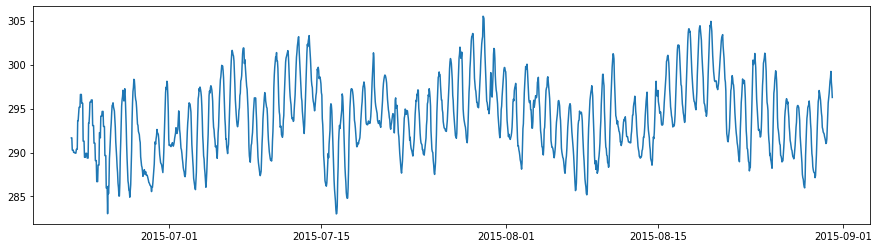

In [9]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(weatherDataMontreal)

In [10]:
windowSize = 24
lowPassFilteredSignal = weatherDataMontreal.rolling(windowSize, center=True).mean()

In [11]:
filteredWeatherData = (weatherDataMontreal - lowPassFilteredSignal).dropna()
#filtered[0:15]
#filtered.dropna(inplace=True)

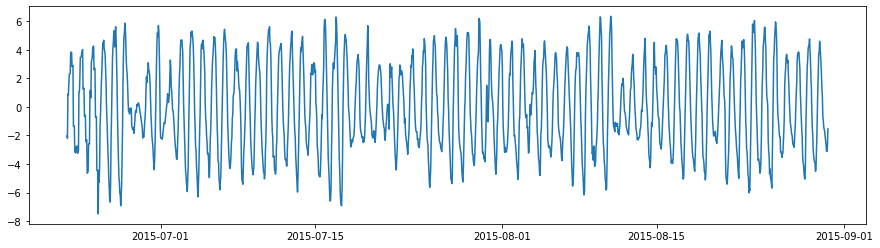

In [12]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(filteredWeatherData)

In [13]:
embeddedWeather = takensEmbedding(filteredWeatherData, 5, 2)

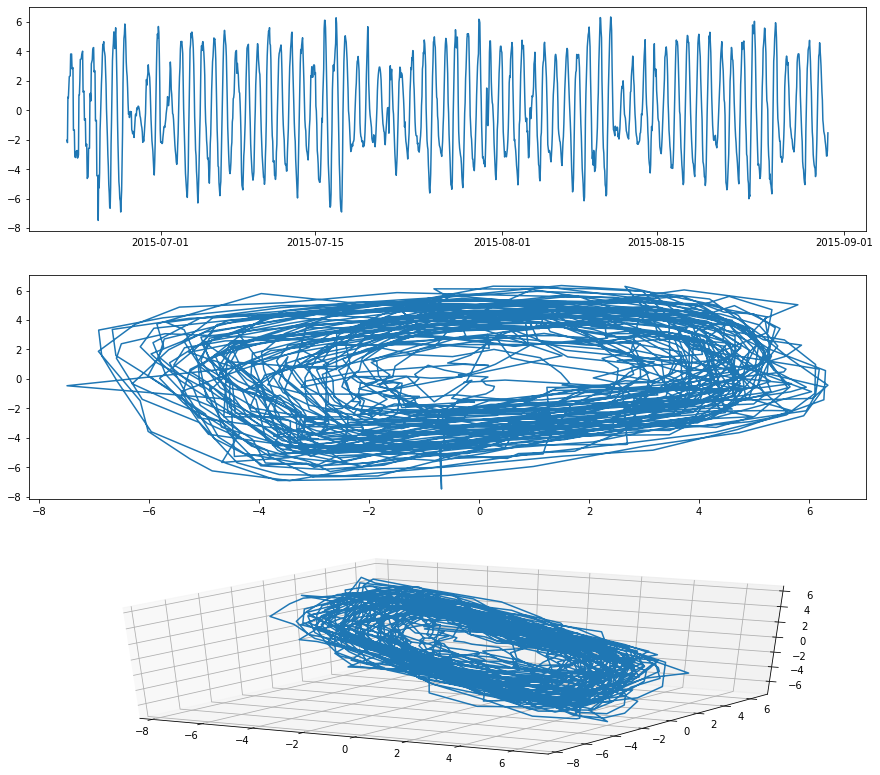

In [14]:
#plot the time-series and the embedded one 
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,14));
ax[0].plot(filteredWeatherData);
ax[1].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[2].axis('off')
#embed into three dimensions
embeddedWeather3 = takensEmbedding(filteredWeatherData, 6,3);
#plot the 3D embedding
ax = fig.add_subplot(3, 1, 3, projection='3d')
ax.plot(embeddedWeather3[0,:],embeddedWeather3[1,:],embeddedWeather3[2,:]);

In [16]:
def mutualInformation(data, delay, nBins):
    "This function calculates the mutual information given the delay"
    I = 0;
    xmax = max(data);
    xmin = min(data);
    delayData = data[delay:len(data)];
    shortData = data[0:len(data)-delay];
    sizeBin = abs(xmax - xmin) / nBins;
    #the use of dictionaries makes the process a bit faster
    probInBin = {};
    conditionBin = {};
    conditionDelayBin = {};
    for h in range(0,nBins):
        if h not in probInBin:
            conditionBin.update({h : (shortData >= (xmin + h*sizeBin)) & (shortData < (xmin + (h+1)*sizeBin))})
            probInBin.update({h : len(shortData[conditionBin[h]]) / len(shortData)});
        for k in range(0,nBins):
            if k not in probInBin:
                conditionBin.update({k : (shortData >= (xmin + k*sizeBin)) & (shortData < (xmin + (k+1)*sizeBin))});
                probInBin.update({k : len(shortData[conditionBin[k]]) / len(shortData)});
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (delayData >= (xmin + k*sizeBin)) & (delayData < (xmin + (k+1)*sizeBin))});
            Phk = len(shortData[conditionBin[h] & conditionDelayBin[k]]) / len(shortData);
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log( Phk / (probInBin[h] * probInBin[k]));
    return I;

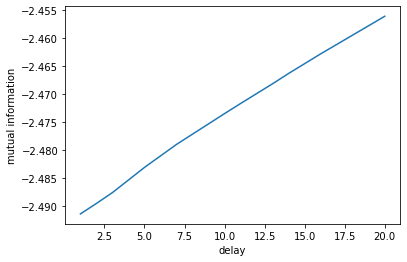

In [17]:
datDelayInformation = []
for i in range(1,21):
    datDelayInformation = np.append(datDelayInformation,[mutualInformation(weatherDataMontreal,i,16)])
plt.plot(range(1,21),datDelayInformation);
plt.xlabel('delay');
plt.ylabel('mutual information');

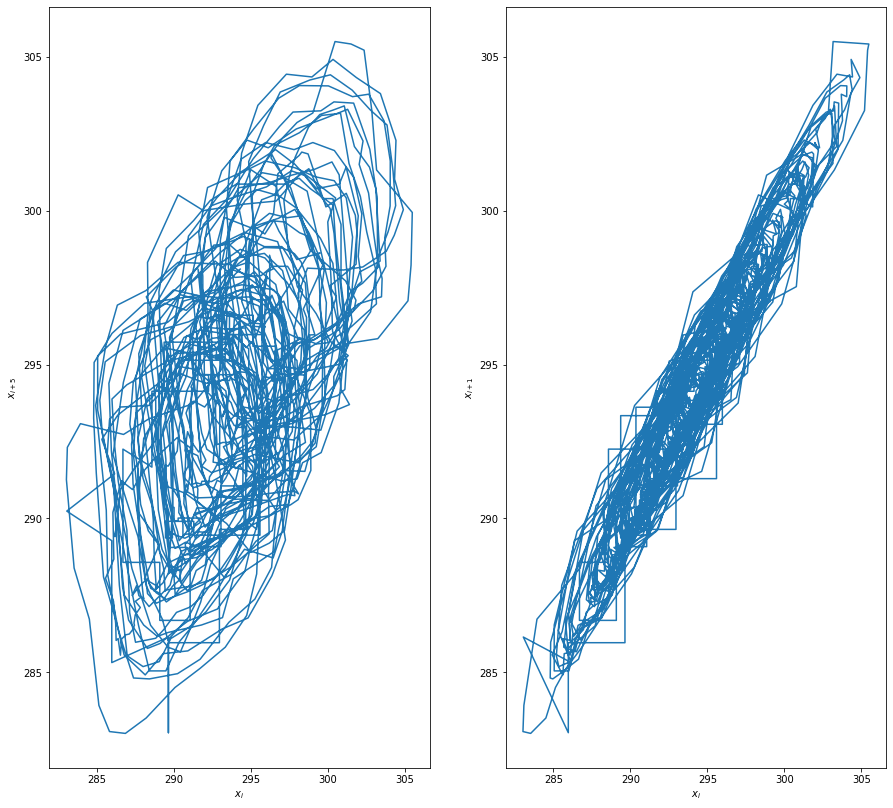

In [18]:
#embedd into two dimensions
embeddedWeather = takensEmbedding(weatherDataMontreal,5,2);
#plot the time-series and the embedded one 
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,14));
ax[0].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[0].set_xlabel('$x_i$');
ax[0].set_ylabel('$x_{i+5}$');
#now with delay=1
embeddedWeather = takensEmbedding(weatherDataMontreal,1,2);
ax[1].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[1].set_xlabel('$x_i$');
ax[1].set_ylabel('$x_{i+1}$');



In [92]:
tempDf = temperatureDF.copy()

In [15]:
def false_nearest_neighours(data,delay,embeddingDimension):
    "Calculates the number of false nearest neighbours of embedding dimension"    
    embeddedData = takensEmbedding(data,delay,embeddingDimension);
    #the first nearest neighbour is the data point itself, so we choose the second one
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData.transpose())
    distances, indices = nbrs.kneighbors(embeddedData.transpose())
    #two data points are nearest neighbours if their distance is smaller than the standard deviation
    epsilon = np.std(distances.flatten())
    nFalseNN = 0
    for i in range(0, len(data)-delay*(embeddingDimension+1)):
        if (0 < distances[i,1]) and (distances[i,1] < epsilon) and ( (abs(data[i+embeddingDimension*delay] - data[indices[i,1]+embeddingDimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN

In [102]:
tempDf.index

DatetimeIndex(['2012-10-01 12:00:00', '2012-10-01 13:00:00',
               '2012-10-01 14:00:00', '2012-10-01 15:00:00',
               '2012-10-01 16:00:00', '2012-10-01 17:00:00',
               '2012-10-01 18:00:00', '2012-10-01 19:00:00',
               '2012-10-01 20:00:00', '2012-10-01 21:00:00',
               ...
               '2017-11-29 15:00:00', '2017-11-29 16:00:00',
               '2017-11-29 17:00:00', '2017-11-29 18:00:00',
               '2017-11-29 19:00:00', '2017-11-29 20:00:00',
               '2017-11-29 21:00:00', '2017-11-29 22:00:00',
               '2017-11-29 23:00:00', '2017-11-30 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=45253, freq=None)

In [101]:
tempDf.loc[tempDf.index >= start & tempDf.index <= stop, 'Montreal']

TypeError: unsupported operand type(s) for &: 'datetime.datetime' and 'DatetimeIndex'

In [41]:
temp = pd.DataFrame(list(range(1,101)))

In [46]:
pd.DataFrame(index=temp.index, data={ 'mean': temp.rolling(10, center=True).mean()})

TypeError: 'int' object is not iterable

In [37]:
//temp.values

SyntaxError: invalid syntax (<ipython-input-37-472898062159>, line 1)

In [59]:
temp.rolling(10, center=True).mean().dropna()

,0
5,5.5
6,6.5
7,7.5
8,8.5
9,9.5
...,...
91,91.5
92,92.5
93,93.5
94,94.5


In [36]:
takensEmbedding(list(range(1,25)), 6, 3)

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18]])

In [33]:
len(list(range(1,10)))

9

In [37]:
def mutualInformation(data, delay, nBins):
    "This function calculates the mutual information given the delay"
    I = 0;
    xmax = max(data);
    xmin = min(data);
    delayData = data[delay:len(data)];
    shortData = data[0:len(data)-delay];
    sizeBin = abs(xmax - xmin) / nBins;
    #the use of dictionaries makes the process a bit faster
    probInBin = {};
    conditionBin = {};
    conditionDelayBin = {};
    for h in range(0,nBins):
        if h not in probInBin:
            conditionBin.update({h : (shortData >= (xmin + h*sizeBin)) & (shortData < (xmin + (h+1)*sizeBin))})
            probInBin.update({h : len(shortData[conditionBin[h]]) / len(shortData)});
        for k in range(0,nBins):
            if k not in probInBin:
                conditionBin.update({k : (shortData >= (xmin + k*sizeBin)) & (shortData < (xmin + (k+1)*sizeBin))});
                probInBin.update({k : len(shortData[conditionBin[k]]) / len(shortData)});
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (delayData >= (xmin + k*sizeBin)) & (delayData < (xmin + (k+1)*sizeBin))});
            Phk = len(shortData[conditionBin[h] & conditionDelayBin[k]]) / len(shortData);
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log( Phk / (probInBin[h] * probInBin[k]));
    return I;

In [43]:
#[ i%5 for i in range(100)]

In [44]:
data = [ i%6 for i in range(100)]
delay = 5   
nBins = 16

I = 0;
xmax = max(data);
xmin = min(data);
delayData = data[delay:len(data)];
shortData = data[0:len(data)-delay];
sizeBin = abs(xmax - xmin) / nBins;
#the use of dictionaries makes the process a bit faster
probInBin = {};
conditionBin = {};
conditionDelayBin = {};
for h in range(0,nBins):
    if h not in probInBin:
        conditionBin.update({h : (shortData >= (xmin + h*sizeBin)) & (shortData < (xmin + (h+1)*sizeBin))})
        probInBin.update({h : len(shortData[conditionBin[h]]) / len(shortData)});
    for k in range(0,nBins):
        if k not in probInBin:
            conditionBin.update({k : (shortData >= (xmin + k*sizeBin)) & (shortData < (xmin + (k+1)*sizeBin))});
            probInBin.update({k : len(shortData[conditionBin[k]]) / len(shortData)});
        if k not in conditionDelayBin:
            conditionDelayBin.update({k : (delayData >= (xmin + k*sizeBin)) & (delayData < (xmin + (k+1)*sizeBin))});
        Phk = len(shortData[conditionBin[h] & conditionDelayBin[k]]) / len(shortData);
        if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
            I -= Phk * math.log( Phk / (probInBin[h] * probInBin[k]));
return I;

TypeError: '>=' not supported between instances of 'list' and 'float'

In [49]:
df = pd.DataFrame(data={"A":list(range(10)), "B": list(range(5,15))})

In [50]:
df

,A,B
0,0,5
1,1,6
2,2,7
3,3,8
4,4,9
5,5,10
6,6,11
7,7,12
8,8,13
9,9,14


In [52]:
df["A"] > df["B"]

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool